In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import sys as sys
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.options.mode.chained_assignment = None

In [2]:
B = r"F:\PERSONAL\Malina\NanoscopeII\mP_LastRound\2024-04-09_Motor_PAINT_Neurons_DIV1_Analysis"
list_dirs = []
for sub_folder in os.listdir(B):
    datadir = B+fr"\{sub_folder}"
    if 'Results_mastertable.csv' not in os.listdir(datadir):
        list_dirs.append(sub_folder)
print(list_dirs)    

['S01_C01_R01', 'S01_C03_R01', 'S01_C04_R01', 'S02_C03_R01', 'S02_C04_R01']


In [3]:
def filter_bead_localisations_v2(df, vid_number, x_start=0, y_start=0, start_average=100, window=50, plotit=True):
    #Apply this to each individual table
    #If there are multiple rows with the same frame number only the onces with max SNR are kept
    SNR_maxes = df.groupby(['Frame_Number']).SNR.transform(max)
    df = df[df.SNR == SNR_maxes]
    #Test if it works with : df[df.Frame_Number.diff() <1]
    #Remove outliers n_std from the mean, mean is taken for window
    df = remove_outliers(points_df = df, n_std = 3, w = 20)
    
    #Fill up empty rows with copies of other rows
    for i in range(1,int(df.Frame_Number.diff().max())): 
        idx = (df.Frame_Number.diff() >1 ) #True after a row has been skipped
        df = df.append(df[idx]) # Add a copy of a row after one has been skipped
        df = df.sort_values(by=['Frame_Number'])
        #make sure all the frame numbers are consequantive
        df['Frame_Number'] = np.where(df.Frame_Number.shift(-1)==df.Frame_Number, df['Frame_Number']-1, df['Frame_Number'])
   
    df = df.sort_values(by=['Frame_Number'], ignore_index=True)
    
    #Detect jump 
    for col in [ 'X_(nm)', 'Y_(nm)']:
        df[f'Diff_{col}'] = df[col].shift() - df[col]
        max_jump = df[f'Diff_{col}'].max()
        print('Max jump: ',max_jump)
        if max_jump > 150: 
            print(f'Jump detected in {col} column, df will be split and rolled seperatly')
            split_loc = df[f'Diff_{col}'].idxmax()
            df_1 = df.iloc[:split_loc,]
            df_2 = df.iloc[split_loc+1:,]

            df_1[f'{col}_rolled'] = df_1[f'{col}'].rolling(window, min_periods=1).mean()
            df_2[f'{col}_rolled'] = df_2[f'{col}'].rolling(window, min_periods=1).mean()
            df = pd.concat([df_1,df_2])

        else: 
            print(f'Rolling_column_{col}_with window size_{window} frames')
            df[f'{col}_rolled'] = df[f'{col}'].rolling(window, min_periods=1).mean()

    if plotit: 
        ax[0].scatter(df['X_(nm)'],df['Y_(nm)'],linewidth=5, color="red")
        ax[0].set_title("Filtered_Bead_localisations")
        
    if vid_number ==0: 
        x_start = df.iloc[0:start_average,:]['X_(nm)_rolled'].mean()
        y_start = df.iloc[0:start_average,:]['Y_(nm)_rolled'].mean()
        
        x_start = round(x_start,4)
        y_start = round(y_start,4)
    
    return df, x_start, y_start

In [4]:
def remove_outliers(points_df = None, n_std = 2, w = 10):     
    def remove_outliers_w(n):

        mean = np.median(n)
        std  = np.std(n)  

        outlier = 0
        if n.iloc[-1] > mean+(n_std*std): 
               outlier = 1
        return outlier 

    points_df['Outlier_X'] = points_df.rolling(w, min_periods=2).apply(remove_outliers_w)['X_(nm)']
    points_df['Outlier_Y'] = points_df.rolling(w, min_periods=2).apply(remove_outliers_w)['Y_(nm)']
    
    print('Outliers in X', points_df.Outlier_X[points_df['Outlier_X']==1.0].count())
    print('Outliers in Y', points_df.Outlier_X[points_df['Outlier_Y']==1.0].count())

    points_df.drop(points_df[points_df['Outlier_X']==1.0].index, inplace=True)
    points_df.drop(points_df[points_df['Outlier_Y']==1.0].index, inplace=True)
    points_df.drop(['Outlier_X', 'Outlier_Y'], axis=1, inplace=True)
    
    return points_df

In [5]:
def make_drift_correction(df, vid_number ,x_start=0, y_start=0, window=500, start_average=100, plotit=True, save=False):
    #Makes a drift correction table from filtered bead coordinates using a rolling window
    #Apply to concatenated table
    
    df['X_drift_(nm)'] = df['X_(nm)_rolled'] - x_start
    df['Y_drift_(nm)'] = df['Y_(nm)_rolled'] - y_start
    Drift_Correction_Bead = df[['Frame_Number', 'X_drift_(nm)', 'Y_drift_(nm)']]
    
    
    df['X_(nm)'] = df['X_(nm)'] - df['Frame_Number'].map(Drift_Correction_Bead.set_index('Frame_Number')['X_drift_(nm)']) 
    df['Y_(nm)'] = df['Y_(nm)'] - df['Frame_Number'].map(Drift_Correction_Bead.set_index('Frame_Number')['Y_drift_(nm)']) 
    
    if plotit:
        
        ax[1].scatter(df['X_drift_(nm)'],df['Y_drift_(nm)'], linewidth=5, color="blue")
        ax[1].set_title("Drift_corrections")
        ax[2].scatter(df['X_(nm)'], df['Y_(nm)'], linewidth=5, color="green")
        ax[2].set_title("Filtered_and_corrected")
    
    if save: 
        Drift_Correction_Bead.to_csv(path_or_buf=fr'{datadir}\Drift_Correction_Bead_window_{window}).csv', index=False)
        print(f'Drift correction table is saved as Drift_Correction_Bead_window_{window}')
    return Drift_Correction_Bead

In [6]:
def filter_table(df):
    df = df.drop(df[df.Track_Length < 6].index)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()  
    return df 

F:\PERSONAL\Malina\NanoscopeII\mP_LastRound\2024-04-09_Motor_PAINT_Neurons_DIV1_Analysis\S01_C01_R01
Beads_Results_0.csv
Outliers in X 4
Outliers in Y 2
Max jump:  14.369999999995343
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  8.779999999998836
Rolling_column_Y_(nm)_with window size_50 frames
1880 1880
Beads_Results_1.csv
Outliers in X 4
Outliers in Y 2
Max jump:  10.159999999996217
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  8.43999999999869
Rolling_column_Y_(nm)_with window size_50 frames
1880 3760
Beads_Results_2.csv
Outliers in X 8
Outliers in Y 3
Max jump:  15.75
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  7.079999999998108
Rolling_column_Y_(nm)_with window size_50 frames
1880 5640
Beads_Results_3.csv
Outliers in X 11
Outliers in Y 4
Max jump:  10.959999999999127
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  10.229999999999563
Rolling_column_Y_(nm)_with window size_50 frames
1879 7519
Beads_Results_4.csv
Outliers in X 6

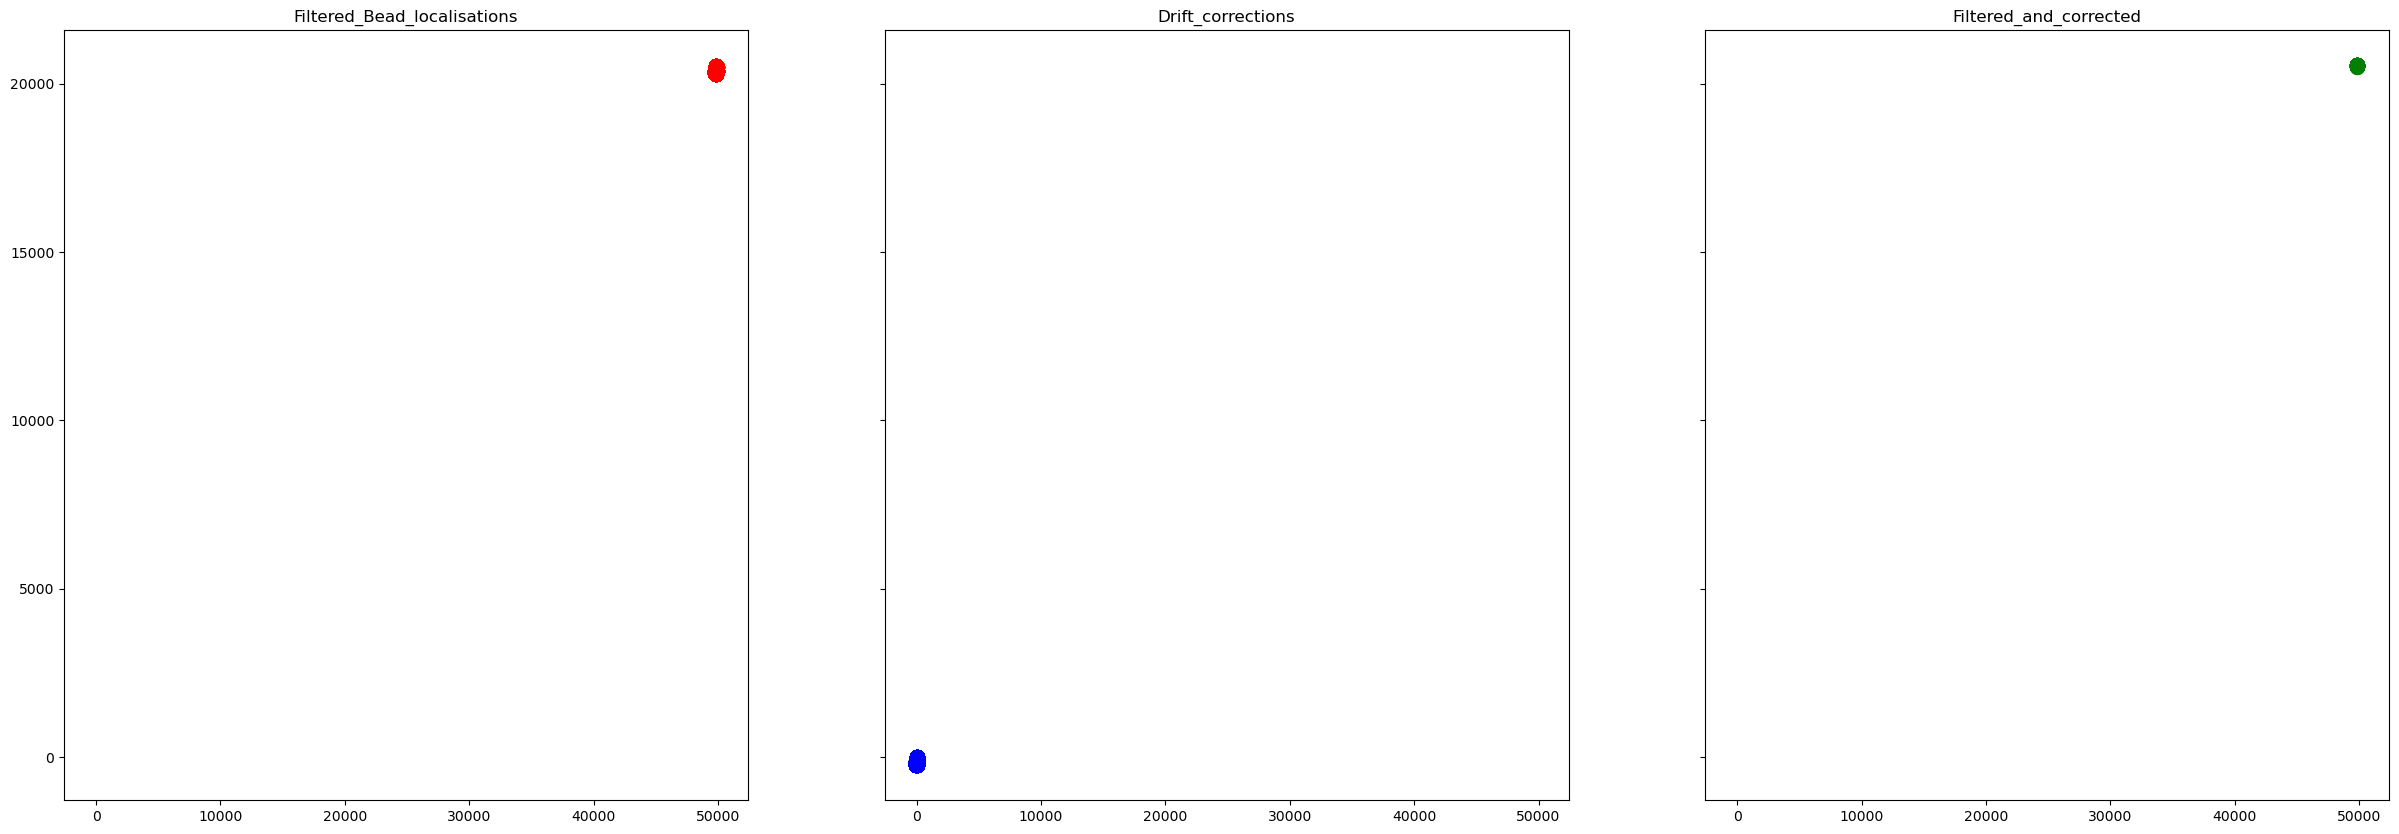

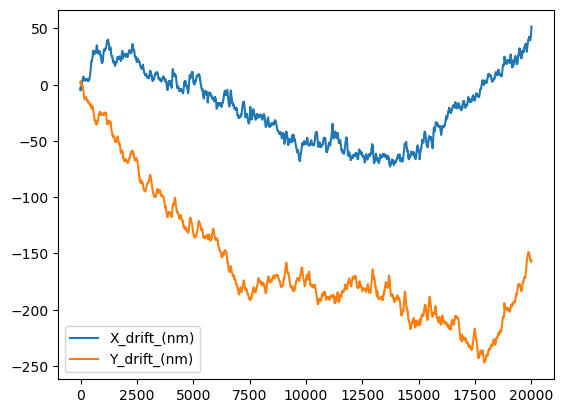

F:\PERSONAL\Malina\NanoscopeII\mP_LastRound\2024-04-09_Motor_PAINT_Neurons_DIV1_Analysis\S01_C03_R01
Beads_Results_0.csv
Outliers in X 9
Outliers in Y 4
Max jump:  15.990000000005239
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  36.88000000000102
Rolling_column_Y_(nm)_with window size_50 frames
2310 2310
Beads_Results_1.csv
Outliers in X 15
Outliers in Y 3
Max jump:  15.889999999999418
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  34.31999999999971
Rolling_column_Y_(nm)_with window size_50 frames
2310 4620
Beads_Results_2.csv
Outliers in X 5
Outliers in Y 1
Max jump:  13.80000000000291
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  32.04000000000087
Rolling_column_Y_(nm)_with window size_50 frames
2310 6930
Beads_Results_3.csv
Outliers in X 9
Outliers in Y 4
Max jump:  12.220000000001164
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  32.279999999998836
Rolling_column_Y_(nm)_with window size_50 frames
2310 9240
Beads_Results_4.csv
Ou

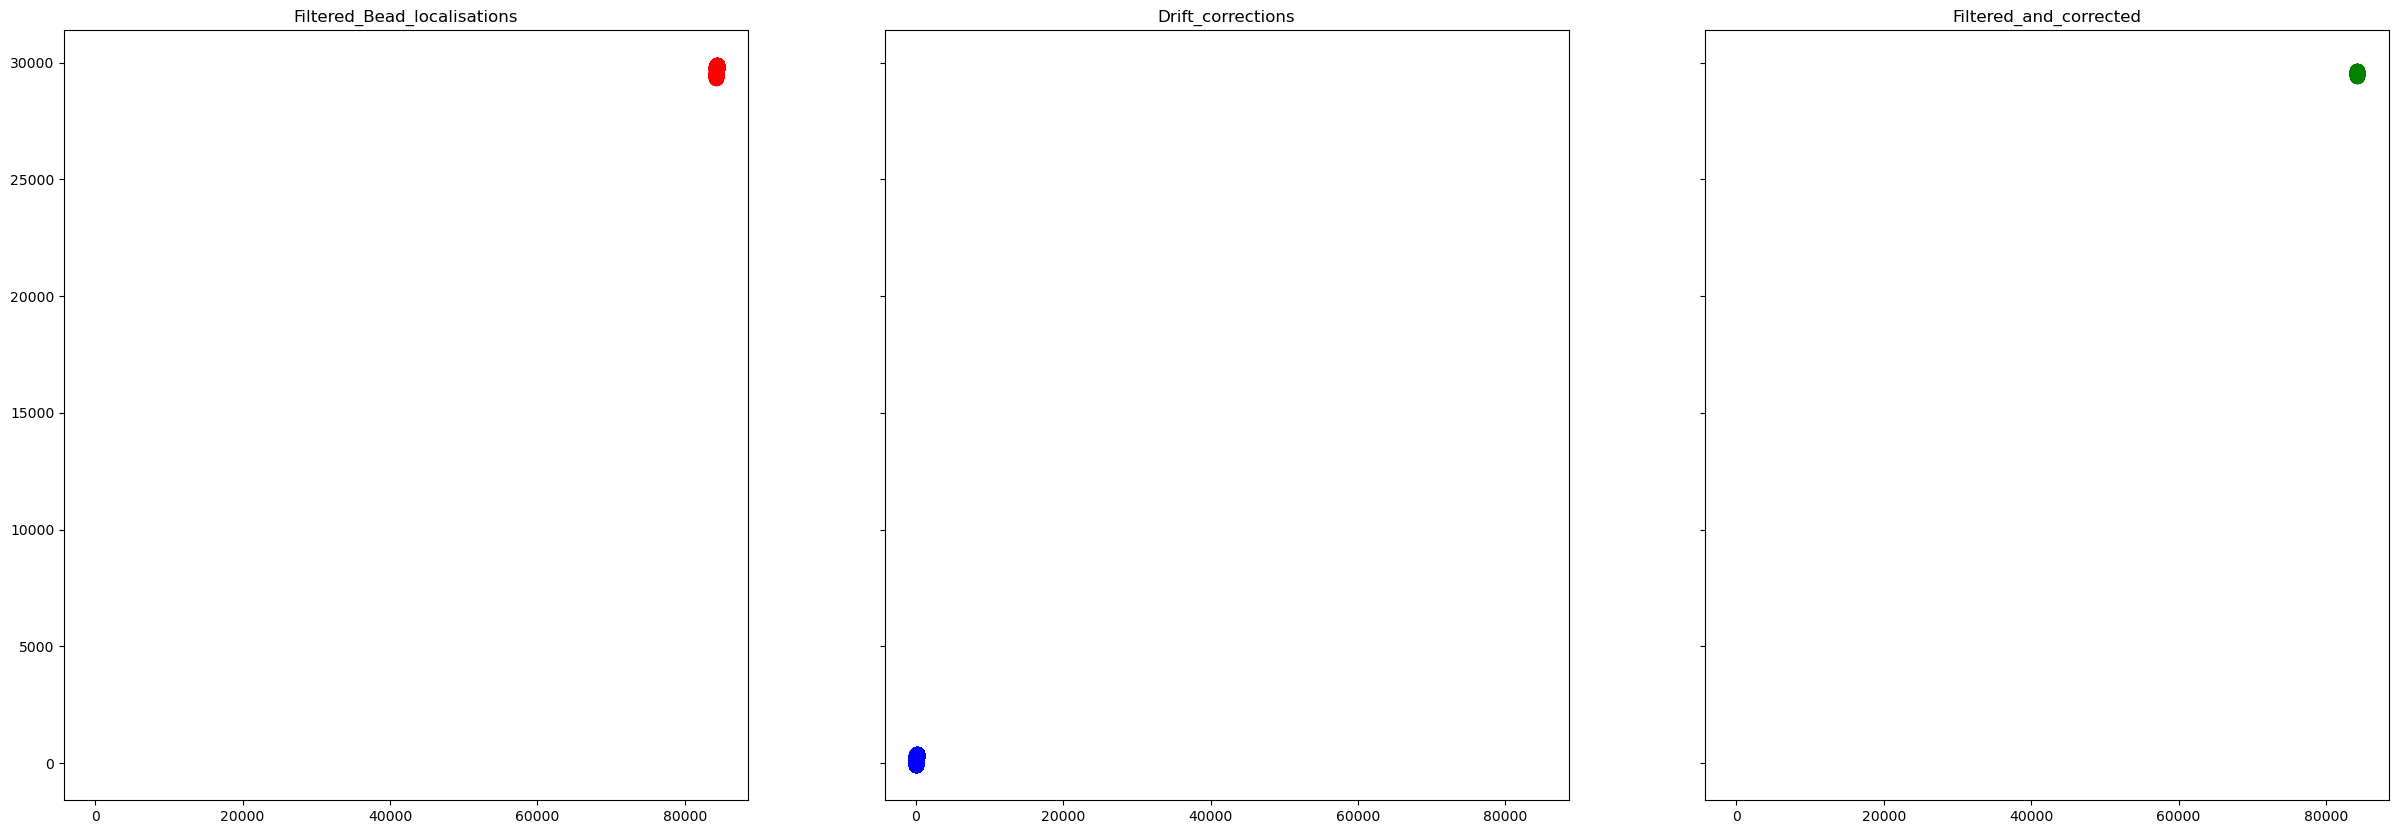

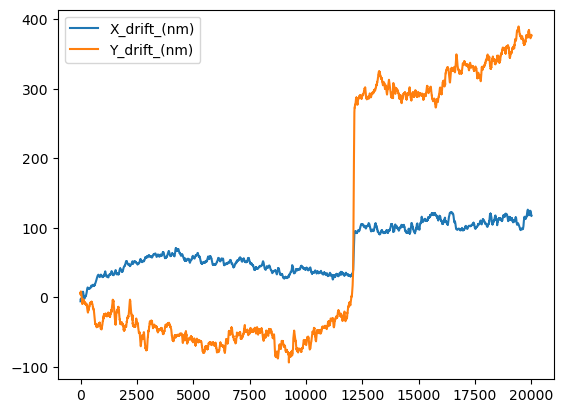

F:\PERSONAL\Malina\NanoscopeII\mP_LastRound\2024-04-09_Motor_PAINT_Neurons_DIV1_Analysis\S01_C04_R01
Beads_Results_0.csv
Outliers in X 3
Outliers in Y 8
Max jump:  8.540000000000873
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  8.659999999996217
Rolling_column_Y_(nm)_with window size_50 frames
2768 2768
Beads_Results_1.csv
Outliers in X 4
Outliers in Y 5
Max jump:  10.44999999999709
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  13.35000000000582
Rolling_column_Y_(nm)_with window size_50 frames
2768 5536
Beads_Results_2.csv
Outliers in X 3
Outliers in Y 8
Max jump:  12.0
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  15.110000000000582
Rolling_column_Y_(nm)_with window size_50 frames
2768 8304
Beads_Results_3.csv
Outliers in X 2
Outliers in Y 15
Max jump:  12.080000000001746
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  10.989999999997963
Rolling_column_Y_(nm)_with window size_50 frames
2768 11072
Beads_Results_4.csv
Outliers in X 2

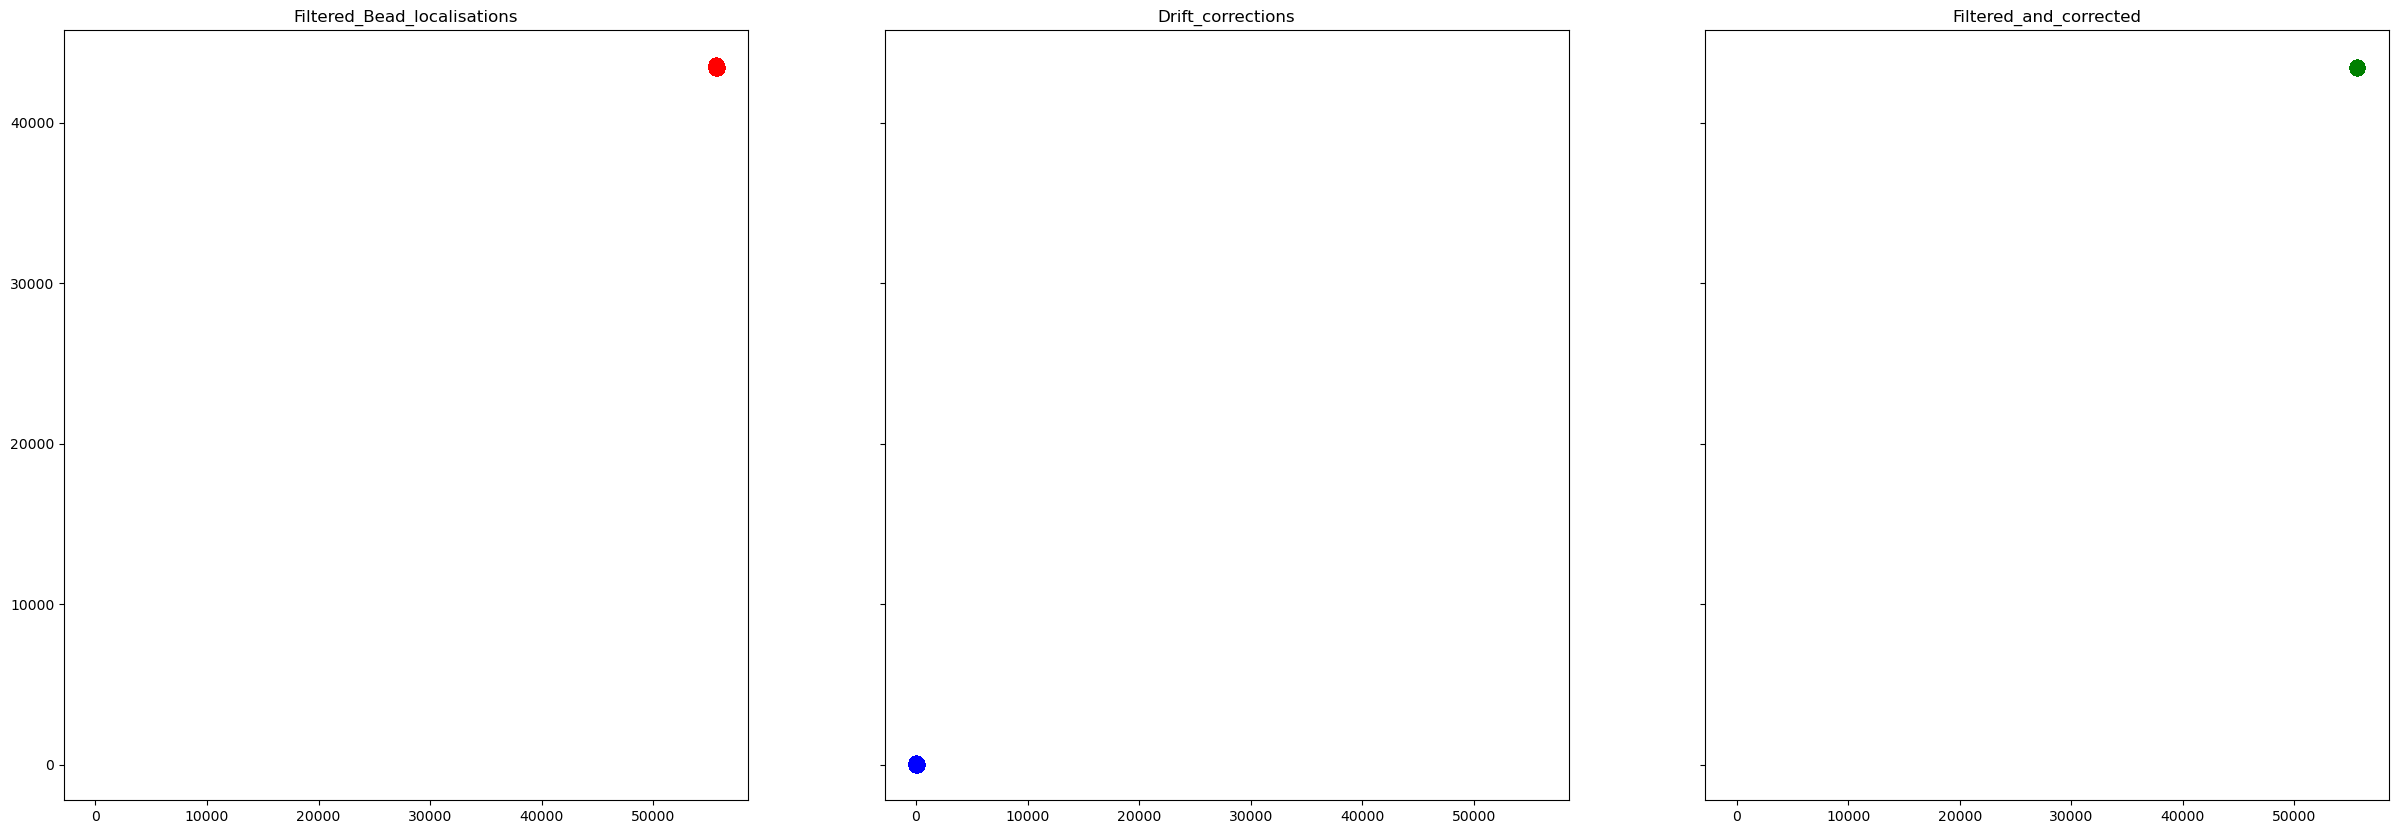

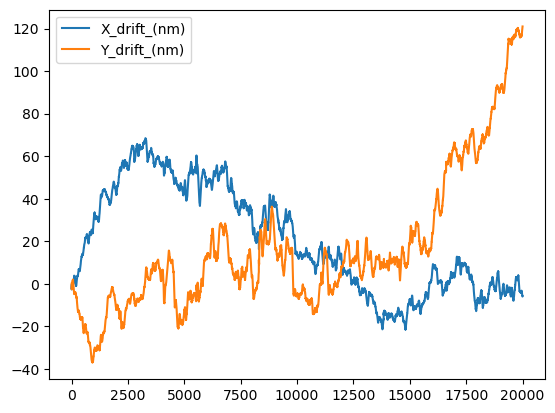

F:\PERSONAL\Malina\NanoscopeII\mP_LastRound\2024-04-09_Motor_PAINT_Neurons_DIV1_Analysis\S02_C03_R01
Beads_Results_0.csv
Outliers in X 7
Outliers in Y 3
Max jump:  2737.2000000000007
Jump detected in X_(nm) column, df will be split and rolled seperatly
Max jump:  11.38000000000011
Rolling_column_Y_(nm)_with window size_50 frames
1719 1719
Beads_Results_1.csv
Outliers in X 7
Outliers in Y 9
Max jump:  11.930000000000291
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  12.949999999999818
Rolling_column_Y_(nm)_with window size_50 frames
1719 3438
Beads_Results_2.csv
Outliers in X 15
Outliers in Y 24
Max jump:  14.440000000002328
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  12.9399999999996
Rolling_column_Y_(nm)_with window size_50 frames
1719 5157
Beads_Results_3.csv
Outliers in X 24
Outliers in Y 41
Max jump:  1122.0
Jump detected in X_(nm) column, df will be split and rolled seperatly
Max jump:  1262.4300000000003
Jump detected in Y_(nm) column, df will be spli

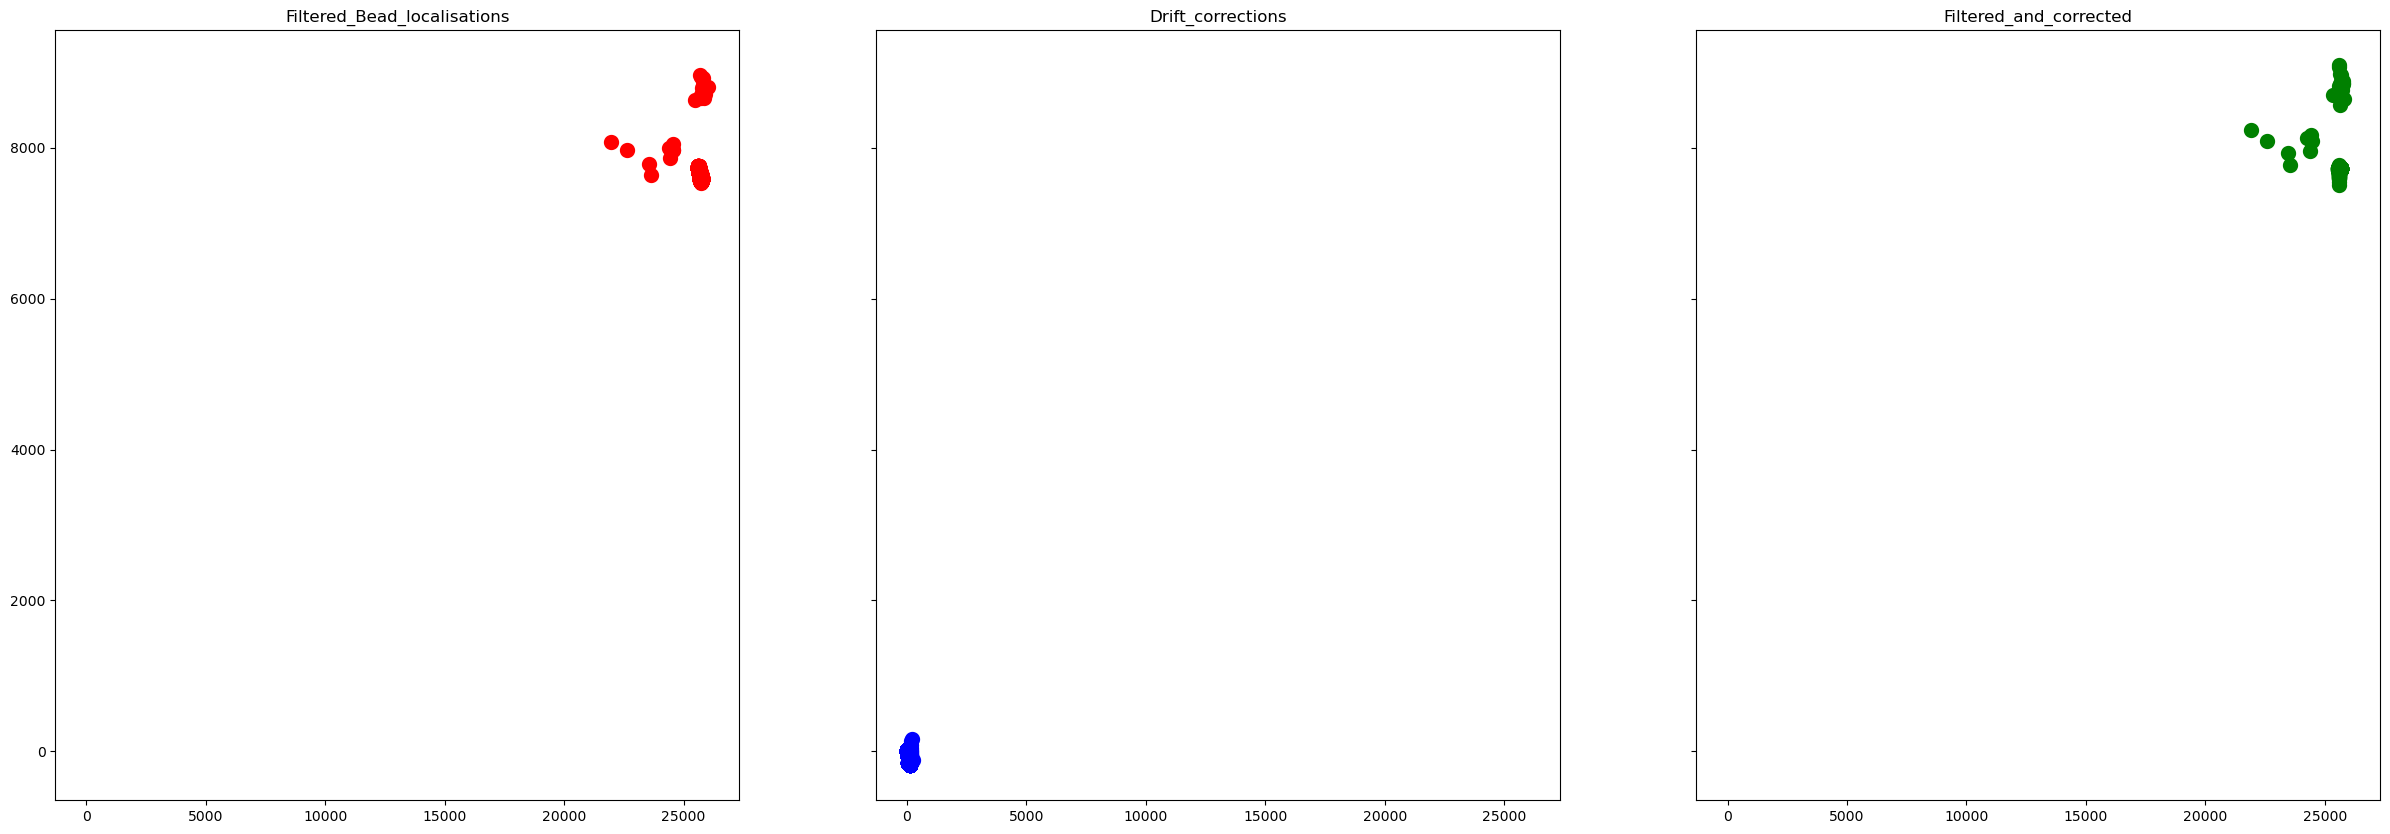

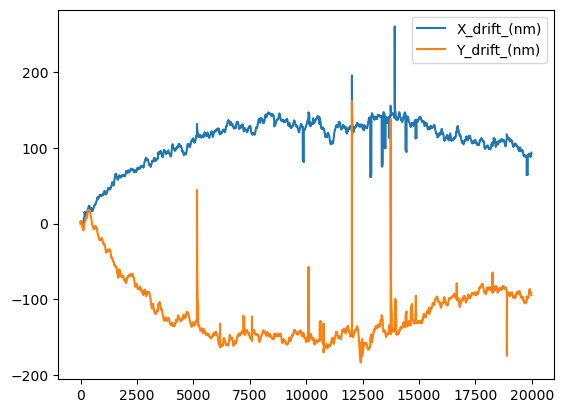

F:\PERSONAL\Malina\NanoscopeII\mP_LastRound\2024-04-09_Motor_PAINT_Neurons_DIV1_Analysis\S02_C04_R01
Beads_Results_0.csv
Outliers in X 8
Outliers in Y 6
Max jump:  8.669999999998254
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  11.37999999999738
Rolling_column_Y_(nm)_with window size_50 frames
3134 3134
Beads_Results_1.csv
Outliers in X 3
Outliers in Y 4
Max jump:  8.690000000002328
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  9.119999999998981
Rolling_column_Y_(nm)_with window size_50 frames
3134 6268
Beads_Results_2.csv
Outliers in X 7
Outliers in Y 5
Max jump:  6.629999999997381
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  8.720000000001164
Rolling_column_Y_(nm)_with window size_50 frames
3134 9402
Beads_Results_3.csv
Outliers in X 7
Outliers in Y 5
Max jump:  9.450000000004366
Rolling_column_X_(nm)_with window size_50 frames
Max jump:  9.760000000002037
Rolling_column_Y_(nm)_with window size_50 frames
3134 12536
Beads_Results_4.csv
Outlie

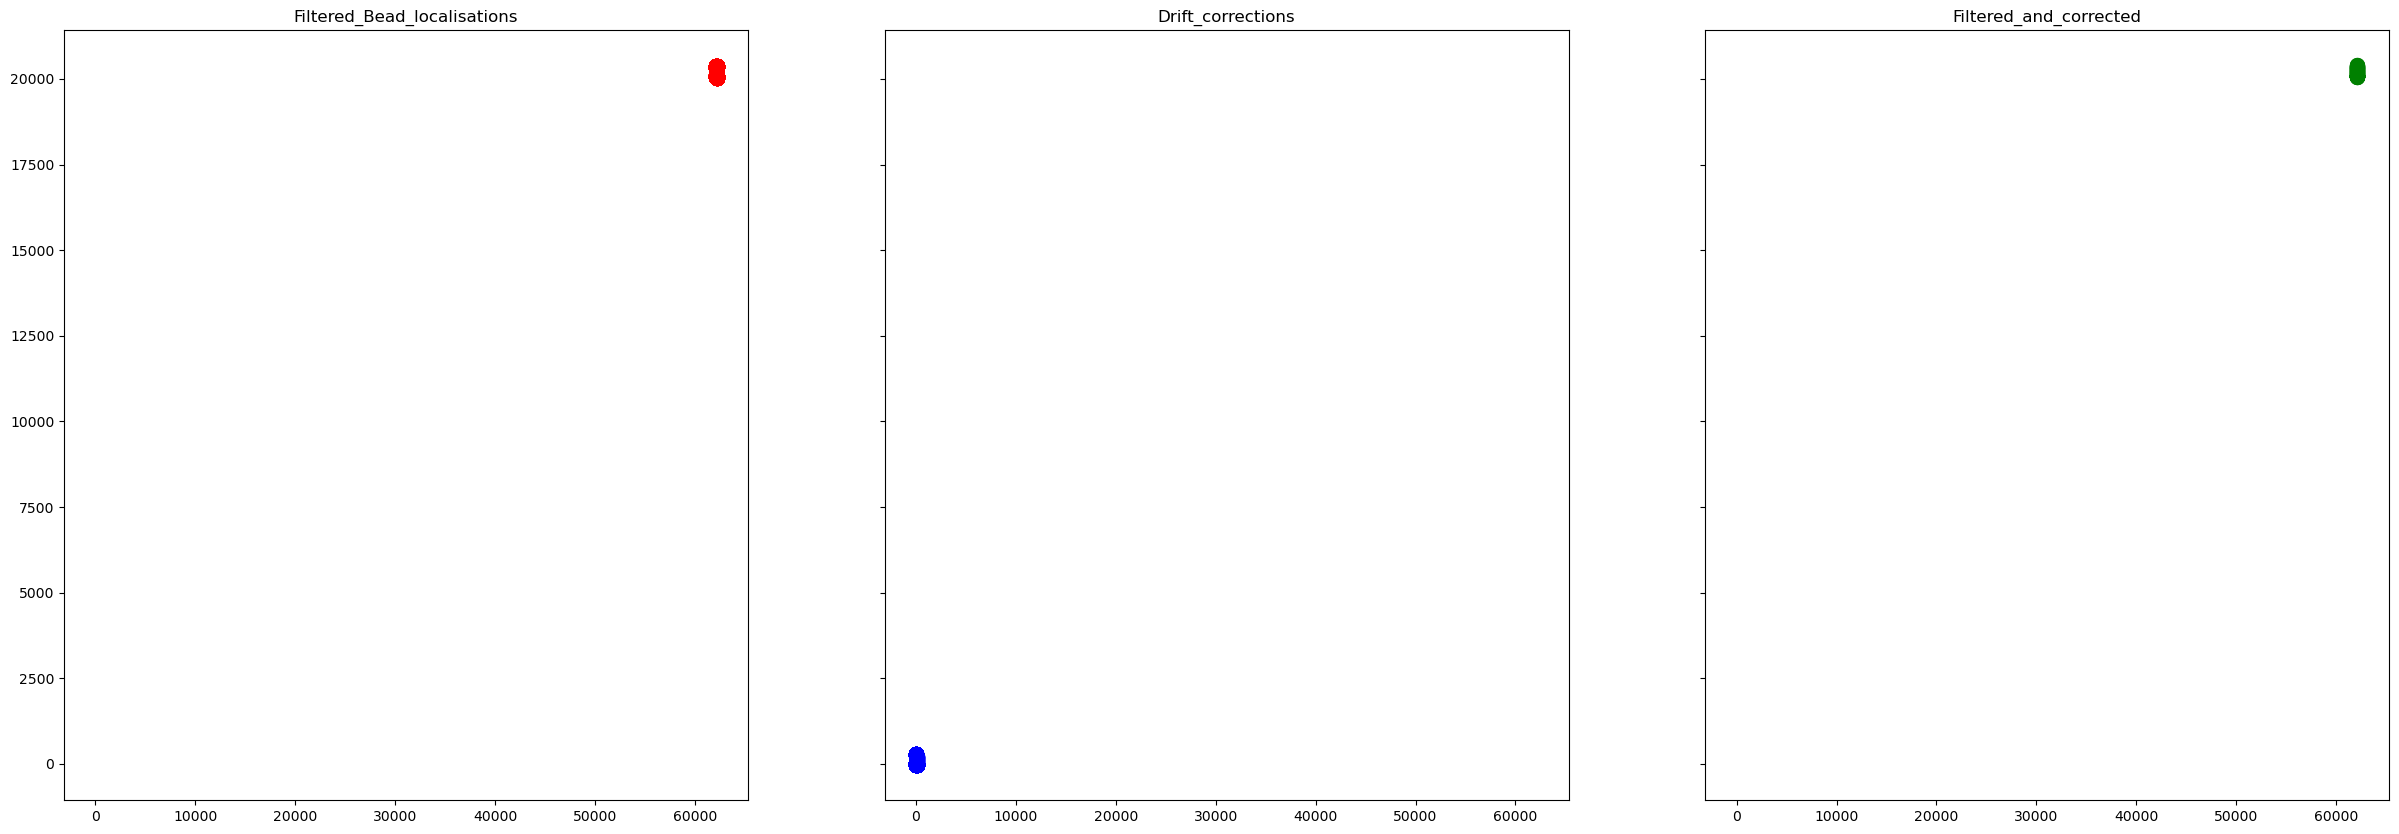

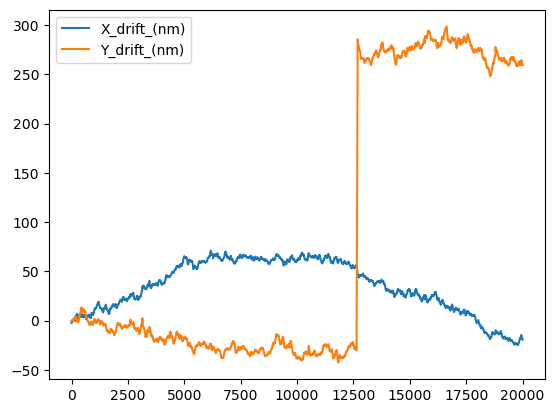

In [7]:
for sub_folder in list_dirs: 
    datadir = B + fr"\{sub_folder}"
    print(datadir)
    window = 50
    max_frame_number = 0
    max_Track_ID = 0 
    mf = 0 
    x_start = 0
    y_start = 0 
    B_table_master = pd.DataFrame()

    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[30, 10])

    for number in range(0,20):
        if os.path.isfile(datadir+f"\Beads_Results_{number}.csv"):
            print(f"Beads_Results_{number}.csv")

            B_table = pd.read_csv(datadir + f"\Beads_Results_{number}.csv")
            #Drop first column 
            B_table = B_table.iloc[: , 1:]

            #Add the last frame number from previous part to all frame numbers. 
            B_table.sort_values(by=['Frame_Number'], inplace=True, ignore_index=True)

            B_table, x_start, y_start = filter_bead_localisations_v2(df=B_table, vid_number=number, x_start=x_start, y_start=y_start,\
                                                                  start_average=100, window=window, plotit=True)

            #save the last frame number for the next round
            mf = B_table.Frame_Number.max()

            #To make one big table for the full data set add frame number 
            B_table["Frame_Number"] = B_table["Frame_Number"] + max_frame_number

            max_frame_number = mf + max_frame_number 
            print(mf, max_frame_number)

            #Add the subtable to the master table with bead coordinates
            B_table_master = pd.concat([B_table_master,B_table], ignore_index=True)

    drift_correction = make_drift_correction(df=B_table_master, vid_number=number, x_start=x_start, y_start=y_start,\
                                             window=window, start_average=100, plotit=True, save=True)
    del B_table

    max_frame_number = 0
    for number in range(0, 20):
        if os.path.isfile(datadir + f"\Results_{number}.csv"):

            if number == 0: 
                master_table = pd.read_csv(datadir + f"\Results_{number}.csv")

                max_frame_number = master_table.Frame_Number.max()
                #master_table.sort_values(by = ['Frame_Number'], inplace = True, ignore_index = True)
                print(max_frame_number)
            else: 
                table = pd.read_csv(datadir+f"\Results_{number}.csv")
                #Drop first column 
                table = table.iloc[: , 1:]

                #Add the last frame number from previous part to all frame numbers. 
                table["Frame_Number"] = table["Frame_Number"] + max_frame_number
                table["Track_ID"] = table["Track_ID"] + max_Track_ID
                #save the last frame number for the next round
                max_frame_number = table.Frame_Number.max()
                max_Track_ID = table.Track_ID.max()
                print('Frame Number', max_frame_number)
                print('Track_ID', max_Track_ID )
                #Add the subtable to the master table
                master_table = pd.concat([master_table,table])

    master_table.to_csv(path_or_buf=fr'{datadir}\Results_mastertable.csv', index=False)         

    master_table['X_(nm)'] = master_table['X_(nm)'] - master_table['Frame_Number'].map(drift_correction.set_index('Frame_Number')['X_drift_(nm)']) 
    master_table['Y_(nm)'] = master_table['Y_(nm)'] - master_table['Frame_Number'].map(drift_correction.set_index('Frame_Number')['Y_drift_(nm)'])
    del drift_correction 
    master_table.to_csv(path_or_buf=fr'{datadir}\Results_mastertable_driftcorrected_{window}.csv', index=False)
    del master_table
    plt.savefig(datadir + r"\Drift_correction.PNG")
    plt.show()
    
    
    dfs = pd.read_csv(datadir + f"\Drift_Correction_Bead_window_50).csv")
    dfs[['X_drift_(nm)', 'Y_drift_(nm)']].plot()
    plt.savefig(datadir + r"\Drift_according_toBead.PNG")
    plt.show()